In [3]:
import pyodbc as pyodbc
from decouple import config

DB_SERVER = config('DB_SERVER', default='localhost')
# DB_SERVER = 'DESKTOP-55GPMAH\SQLE08' # con nombre de instancia
# DB_SERVER = '192.168.1.37,51370' # el puerto separado con coma
DB_PORT = config('DB_PORT', default='1433')
DB_NAME = config('DB_NAME', default='dbname')
DB_USER = config('DB_USER', default='username')
DB_PASSWORD = config('DB_PASSWORD', default='password')

connStr = ('DRIVER={ODBC Driver 17 for SQL Server};Server=%s,%s;port=%s;Database=%s;uid=%s;pwd=%s;') \
         % (DB_SERVER, DB_PORT, DB_PORT, DB_NAME, DB_USER, DB_PASSWORD)
print(connStr)
cnxn = pyodbc.connect(connStr)
cursor = cnxn.cursor()
print(cnxn, cursor)

DRIVER={ODBC Driver 17 for SQL Server};Server=172.25.0.124,60388;port=60388;Database=ReplCS;uid=uniconuser01;pwd=87654321;
<pyodbc.Connection object at 0x7faa59e38920> <pyodbc.Cursor object at 0x7faa59ce15d0>


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [5]:
import textwrap
sql = textwrap.dedent("""
select sm.* ,
	CASE 
		WHEN sm.diff_media BETWEEN 0 AND 29.999999 THEN 1
		WHEN sm.diff_media BETWEEN 30 AND 59.999999 THEN 2
		WHEN sm.diff_media BETWEEN 60 AND 89.999999 THEN 3
		ELSE 4
	END AS media_scale,
	CONVERT(INT, 
		CASE 
			WHEN ISNUMERIC(SUBSTRING(sm.truck_code,1,1))=1 THEN sm.truck_code 
			ELSE SUBSTRING(sm.truck_code,2,LEN(sm.truck_code)-1) 
		END) 
	AS truck_code_num
from replcs.dbo.trim_trama_sum sm WITH(NOLOCK)
JOIN [ReplCS].[dbo].[tgps] WITH(NOLOCK) ON  sm.order_date=CONVERT(DATE,tgps.order_date) 
									  --AND sm.truck_code=RTRIM(LTRIM(tgps.truck_code))
									  AND sm.tkt_code=RTRIM(LTRIM(tgps.tkt_code))
									  AND sm.order_code=RTRIM(LTRIM(tgps.order_code))
WHERE sm.order_date = '2018-05-16' -- CONVERT(DATE,GETDATE()) 
	and  sm.num_rec > 0 and fe_ini_receiver is not null
ORDER BY sm.order_date
	,sm.truck_code
	,sm.tkt_code
""")

In [7]:
dfQ = pd.read_sql(sql, cnxn)
print(dfQ.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 17 columns):
order_date         163 non-null object
truck_code         163 non-null object
tkt_code           163 non-null object
order_code         163 non-null object
num_sen            163 non-null int64
fe_ini_sender      163 non-null datetime64[ns]
fe_fin_sender      163 non-null datetime64[ns]
num_rec            163 non-null int64
fe_ini_receiver    163 non-null datetime64[ns]
fe_fin_receiver    163 non-null datetime64[ns]
diff_media         163 non-null float64
diff_mediana       163 non-null float64
diff_moda          163 non-null float64
diff_rango         163 non-null float64
reg_date           163 non-null datetime64[ns]
media_scale        163 non-null int64
truck_code_num     163 non-null int64
dtypes: datetime64[ns](5), float64(4), int64(4), object(4)
memory usage: 21.7+ KB
None


In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size

In [9]:
scale_colors = {
        1:'#00FF00',
        2:'#FFFF00',
        3:'#4169E1',
        4:'#FF0000'
    }

ref_colors = [scale_colors[x] for x in dfQ['media_scale']]

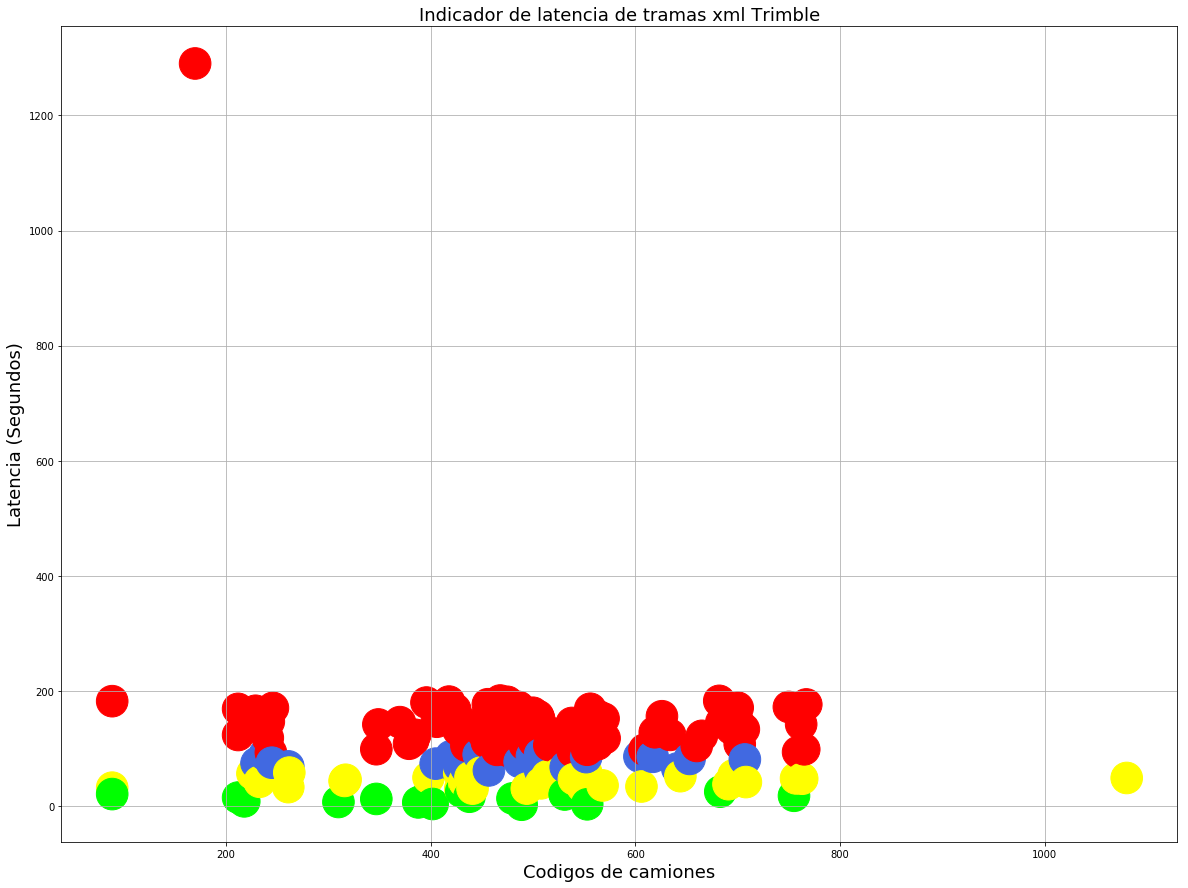

In [10]:
plt.scatter(dfQ.truck_code_num, dfQ.diff_media, s=1000, c=ref_colors)
plt.title('Indicador de latencia de tramas xml Trimble', fontsize=18)
plt.xlabel('Codigos de camiones', fontsize=18)
plt.ylabel('Latencia (Segundos)', fontsize=18)
plt.grid(True)

In [11]:
from bokeh.plotting import figure, show, output_file, save

TOOLS="hover,crosshair,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select,poly_select,lasso_select,"

In [12]:
p = figure(tools=TOOLS, plot_width=1200, plot_height=800)
p.scatter(dfQ.truck_code_num, dfQ.diff_media, 
          fill_color=ref_colors, fill_alpha=0.6, 
          line_color=None, size=25)

output_file("indicadores_trimble.html", title="Indicadores de latencia de tramas de Trimble")
save(p)

'/app/indicadores_trimble.html'